# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [50]:
candidateno=277260 #this MUST be updated to your candidate number so that you get a unique data sample

In [51]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [52]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [53]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['for', 'the', 'first', 'reel', 'of', 'girls', 'town', ...], 'pos')


# **QUESTION 1**

1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

## **Answer of 1.Question a) & b)**

### **Normalization in Training Dataset:**

#### **Non-alphabetical character and stop word normalization:**

In [54]:
#the total number of stop words in training data
count_stopwords=0
cnt_word=0
for i in training_data:
  for word in i[0]:
    cnt_word+=1
    if (word.isalpha()==False) or (word in stopwords.words('english')):
      count_stopwords+=1
print("The total number of stop words in training dataset: {}({:.2f}% of total words)".format(count_stopwords,count_stopwords*100/cnt_word))

The total number of stop words in training dataset: 613255(55.78% of total words)


In [55]:
#making the first normalization in training data by removing stopwords,and the words which contain unalphabetical characters
normalized_1=[]
for i in training_data:
  alist=[]
  atuple=()
  for word in i[0]:
    if word.isalpha() and (word not in stopwords.words('english')):
      alist.append(word)
  atuple=(alist,i[1])
  normalized_1.append(atuple)

In [56]:
#the total number of stop words in training data after the first normalization
count_stopwords_1=0
for i in normalized_1:
  for word in i[0]:
    if (word.isalpha()==False) or (word in stopwords.words('english')):
      count_stopwords_1+=1
print("The total number of stop words in normalized training dataset: {}".format(count_stopwords_1))

The total number of stop words in normalized training dataset: 0


####  **Lemmatization:**



In [57]:
#libraries for lemmatization
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [58]:
#determining lemmatizer function to a variable not to call it by writing many characters every time
wnl = WordNetLemmatizer()

In [59]:
#checking whether it works
print(wnl.lemmatize('dogs'))

dog


In [60]:
#checking the number of characters in total reviews before lemmatization
cw_bef_lem=0
for i in normalized_1:
  for word in i[0]:
    cw_bef_lem+=len(word)

print("The length of words in the reviews before lemmatization: {} characters".format(cw_bef_lem))

The length of words in the reviews before lemmatization: 2932952 characters


In [61]:
#lemmatization of normalized data
#after this part, the number of frequency of some words can increase because of removing suffixes from the words
normalized_training_data=[]
for i in normalized_1:
  alist=[]
  atuple=()
  for word in i[0]:
    alist.append(wnl.lemmatize(word))
  atuple=(alist,i[1])
  normalized_training_data.append(atuple)

In [62]:
#checking the number of characters in total reviews after lemmatization
cw_aft_lem=0
for i in normalized_training_data:
  for word in i[0]:
    cw_aft_lem+=len(word)
dif=cw_bef_lem-cw_aft_lem
print("The length of words in the reviews after lemmatization: {}, the decrease is {}({:.2f}%) characters".format(cw_aft_lem,dif,dif*100/cw_bef_lem))

The length of words in the reviews after lemmatization: 2873836, the decrease is 59116(2.02%) characters


#### **Examination of lowercase necessity:**

In [63]:
# checking whether lowercase is needed
empty_list=[]
for i in normalized_training_data:
  for word in i[0]:
    if word.islower() is not True:
      empty_list.append(word)
if len(empty_list)>0:
  print('lowercase normalization is necessary in {} words'.format(len(empty_list)))
elif len(empty_list)==0:
  print('lowercase normalization is not necessary')

lowercase normalization is not necessary




###  **Frequency Distributions:**



In [64]:
#creating a frequency distribution for both positive and negative
positive_frequent=FreqDist()
negative_frequent=FreqDist()

for i,label in normalized_training_data:
    data=tuple(i)
    if label=='pos':
      for a in data:
        positive_frequent[a]+=1
    elif label=='neg':
      for a in data:
        negative_frequent[a]+=1

In [65]:
# the most frequent 10 words in positive
positive_frequent.most_common(10)

[('film', 4222),
 ('one', 2243),
 ('movie', 2195),
 ('character', 1397),
 ('like', 1289),
 ('time', 1073),
 ('story', 957),
 ('scene', 953),
 ('get', 927),
 ('make', 925)]

In [66]:
# the most frequent 10 words in negative
negative_frequent.most_common(10)

[('film', 3377),
 ('movie', 2657),
 ('one', 1994),
 ('like', 1323),
 ('character', 1277),
 ('get', 1055),
 ('time', 962),
 ('even', 932),
 ('scene', 897),
 ('make', 885)]



###   **Creating Representative Word Lists:**


In [67]:
# taking the differences in both positive and negative frequency list in order to find out which word is more relevant to which category
difference_pos=positive_frequent-negative_frequent
sorted_diff_pos=difference_pos.most_common()
filtered_pos=[word for (word,num) in sorted_diff_pos if num>10]

difference_neg=negative_frequent-positive_frequent
sorted_diff_neg=difference_neg.most_common()
filtered_neg=[(word) for (word,num) in sorted_diff_neg if num>10]


In [71]:
#Representative Positive Word List
# taking the first 10 most common words in positive list
pos_represent=filtered_pos[:10]
print("10 Positive Content Words:")
print("---------------------------")
pos_represent

10 Positive Content Words:
---------------------------


['film',
 'life',
 'also',
 'performance',
 'well',
 'story',
 'great',
 'world',
 'one',
 'best']

In [72]:
#Representative Negative Word List
# taking the first 10 most common words in negative list
neg_represent=filtered_neg[:10]
print("10 Negative Content Words:")
print("---------------------------")
neg_represent

10 Negative Content Words:
---------------------------


['bad',
 'movie',
 'plot',
 'worst',
 'nothing',
 'minute',
 'get',
 'script',
 'could',
 'attempt']

##**Answer of 1.Question c)**
1.   At first, I created a normalized_1 data by **removing stopwords,and the words which contain unalphabetical characters** (these covered **55.78%** of the total words in training data, before the first normalization).

2. Next, I applied **lemmatization** in order to increase the frequencies of the words in frequency distributions. After the lemmatization the number of total characters decreased by **2.02%**. For example, the word of begin has other forms like beginning,and began. After lemmatize it, it will find exactly the root of word (begin). Thus, each frequency increases, while the number of different word types of the same words decrease. Also, I checked whether **lowercase normalization** is necessary, but it can be seen that it's not necessary, since the review list doesn't contain any capital letters.

3.   After that, I found the frequencies of the each element(word) in the lists in order to find the most frequent words in each review type. Then, I subtracted the numbers of frequencies from each other to understand which words are more relevant to which category (positive or negative).

4.  At last, I took the most 10 frequent words from each list, because we needed to take the first 10 among them.

# **QUESTION 2**

2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


## **Answer of 2.Question a)**

### **Normalization in Test Dataset:**


#### **Non-alphaabetical character and stop word normalization:**




In [73]:
#the total number of stop words in testing data before the first normalization
count_stopwords_test=0
cnt_word_test=0
for i in testing_data:
  for word in i[0]:
    cnt_word_test+=1
    if (word.isalpha()==False) or (word in stopwords.words('english')):
      count_stopwords_test+=1
print("The total number of stop words in testing dataset: {}({:.2f}% of total words)".format(count_stopwords_test,count_stopwords_test*100/cnt_word_test))

The total number of stop words in testing dataset: 269022(55.54% of total words)


In [74]:
#making the first normalization in testing data by removing stopwords,and the words which contain unalphabetical characters
normalized_1_test=[]
for i in testing_data:
  alist=[]
  atuple=()
  for word in i[0]:
    if word.isalpha() and (word not in stopwords.words('english')):
      alist.append(word)
  atuple=(alist,i[1])
  normalized_1_test.append(atuple)

In [76]:
#the total number of stop words in testing data after the first normalization
count_stopwords_1_test=0
for i in normalized_1_test:
  for word in i[0]:
    if (word.isalpha()==False) or (word in stopwords.words('english')):
      count_stopwords_1_test+=1
print("The total number of stop words in normalized training dataset after the first normalization: {}".format(count_stopwords_1_test))

The total number of stop words in normalized training dataset after the first normalization: 0




####  **Lemmatization:**



In [77]:
#checking the number of characters in total reviews before lemmatization on testing dataset
test_bef_lem=0
for i in normalized_1_test:
  for word in i[0]:
    test_bef_lem+=len(word)

print("The length of words in the reviews before lemmatization: {} characters".format(test_bef_lem))

The length of words in the reviews before lemmatization: 1301472 characters


In [78]:
#lemmatization of testing data
normalized_testing_data=[]
for i in normalized_1_test:
  alist=[]
  atuple=()
  for word in i[0]:
    alist.append(wnl.lemmatize(word))
  atuple=(alist,i[1])
  normalized_testing_data.append(atuple)

In [79]:
#checking the number of characters in total reviews after lemmatization
test_aft_lem=0
for i in normalized_testing_data:
  for word in i[0]:
    test_aft_lem+=len(word)
dif_lem_test=test_bef_lem-test_aft_lem
print("The length of words in the reviews after lemmatization: {}, the decrease is {}({:.2f}%) characters".format(test_aft_lem,dif_lem_test,dif_lem_test*100/test_bef_lem))

The length of words in the reviews after lemmatization: 1275327, the decrease is 26145(2.01%) characters


In [80]:
# checking whether lowercase is needed on testing_data
empty_list=[]
for i in normalized_testing_data:
  for word in i[0]:
    if word.isalpha() and word.islower() is not True:
      empty_list.append(word)
if len(empty_list)>0:
  print('lowercase normalization is necessary in {} words'.format(len(empty_list)))
elif len(empty_list)==0:
  print('lowercase normalization is not necessary')

lowercase normalization is not necessary




###   **Creating Wordlist Classifier Function:**


In [81]:
#creating wordlist classifier function
def wordlist_classifier(normalized_testing_data,filtered_pos,filtered_neg):
  sum_p=0
  sum_n=0
  notr=0
  number_pos=0
  number_neg=0
  predicted_list=[]
  result=0
  #"i" takes the list of reviews, while "label" takes the value of either pos or neg
  for i,label in normalized_testing_data:
    #word_list must be equal to an empty list to add new values each time
    word_list=[]
    for word in i:
      #adding the words to the list one by one
      word_list.append(word)
      #finding the sum of negative and positive words in the list
      if word in filtered_pos:
        sum_p+=1
      elif word in filtered_neg:
        sum_n+=1
    #comparison which one is bigger or equal
    if sum_p>sum_n:
      result='pos'
      number_pos+=1
    elif sum_n>sum_p:
      result='neg'
      number_neg+=1
    #if it is equal(as for notr reviews), then the result will be given as positive
    else:
      notr+=1
      result='neg'
    #adding them to a tuple
    c=(i,result)
    #adding tuple into the predicted list in order to make the same data type as testing data set
    predicted_list.append(c)
    #total positive and negative numbers must be equal 0, otherwise the cumulative value will be added each time
    sum_p=0
    sum_n=0
  #finding the total number of predicted reviews, whether the size of it is the same as our original testing data set
  total=number_pos+number_neg+notr
  return number_pos,number_neg,total,notr,predicted_list


In [82]:
#working wordlist classifier function
(number_pos,number_neg,total,notr,predicted_list)=wordlist_classifier(normalized_testing_data,filtered_pos[:10],filtered_neg[:10])

In [92]:
#printing results
print("The number of positive prediction: {}\nThe number of negative prediction: {}\nTotal number of predicted data: {}".format(number_pos,number_neg,total))
print("The number of reviews which turned from notr to negative: {}".format(notr))
print("-------------------------------------------------------------------------")
print("The label of the first review of the predicted list: {}".format(predicted_list[0][-1]))


The number of positive prediction: 450
The number of negative prediction: 126
Total number of predicted data: 600
The number of reviews which turned from notr to negative: 24
-------------------------------------------------------------------------
The label of the first review of the predicted list: pos


## **Answer of 2.Question b)**

**Normalization on Testing Dataset Part:**
1. At first, I created a normalized_1_test data by **removing stopwords,and the words which contain unalphabetical characters** (these covered **55.54%** of the total words in training data, before the first normalization).

2. Next, I applied **lemmatization** in order to increase the possibility of matching in a better way for each word. After the lemmatization the number of total characters decreased by **2.01%**.

3. **Lowercase normalisation** wasn't necessary for the testing dataset as well.
-------------------
**Creating Classifier Part:**
1. I took the data as lists,and labels by 2 different variables in testing data respectively. After that, I added inner loop to take each element(word) from the list. In this way, I could check whether this element could be found in any of the 10-most-frequent-words list created for both positive, and negative.

2.   If the element can be found in any of these lists, I increased the number of relevant representative number by counters.

3. Even though some of the reviews have equal numbers of negative and positive reviews (in other words these were notr ones), I counted them as negative reviews.

4. I stored them in the same way as the dataset like **[([review-1],’label-1’),([review-2],’label-2’)…]**

5. At last, I printed all of the findings.

















# **QUESTION 3**

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

## **Answer of 3.Question a)**



###   **Creating a Function for Score Calculation in Wordlist Classifier:**



In [93]:
#creating a function to calculate the score parameters for Wordlist Classifier
def wordlist_score_calculator(predicted_list,normalized_testing_data):
  TP=0
  TN=0
  FP=0
  FN=0
  for (i_pred,label_pred),(i_act,label_act) in zip(predicted_list,normalized_testing_data):
    #True positive calculation
    if label_act=='pos' and label_pred=='pos':
      TP+=1
    #True negative calculation
    elif label_act=='neg' and label_pred=='neg':
      TN+=1
    #False positive calculation
    elif label_act=='neg' and label_pred=='pos':
      FP+=1
    #False negative calculation
    elif label_act=='pos' and label_pred=='neg':
      FN+=1

  Total=TP+TN+FP+FN
  Accuracy=(TP+TN)/Total
  Error_rate=(FN+FP)/Total
  Recall=TP/(TP+FN)
  Precision=TP/(TP+FP)
  F1_score=2*Precision*Recall/(Precision+Recall)
  return TP,TN,FP,FN,Total,Accuracy,Error_rate,Recall,Precision,F1_score


### **Printing the Score Parameters for Wordlist Classifier:**

In [108]:
#printing the score parameters for Wordlist Classifier
print("The Scores for Wordlist Classifier:")
print("-----------------------------------")
(TP,TN,FP,FN,Total,Accuracy,Error_rate,Recall,Precision,F1_score)=wordlist_score_calculator(predicted_list,normalized_testing_data)
print("TP: {}\nTN: {}\nFP: {}\nFN: {}\nTotal: {}\nAccuracy: {:.2f}\nError_rate: {:.2f}\nRecall: {:.2f}\nPrecision: {:.2f}\nF1 Score: {:.2f}".format(TP,TN,FP,FN,Total,Accuracy,Error_rate,Recall,Precision,F1_score))
print("-----------------------------------")

The Scores for Wordlist Classifier:
-----------------------------------
TP: 258
TN: 108
FP: 192
FN: 42
Total: 600
Accuracy: 0.61
Error_rate: 0.39
Recall: 0.86
Precision: 0.57
F1 Score: 0.69
-----------------------------------


## **Answer of 3.Question b)**

1.   To use accuracy all the time as an indicator of our model can cause some problems. Specially, if we have a unbalanced data.

2. If we had a dataset in which the positive reviews cover 95% of all, the predicted negative reviews would have been really less. So, the accuracy would be pretty high, since our model could detect positive more likely.

3. If a disease-diagnosing model which were trained by an unbalanced data is taken as an example, we can think that our model works well because of having a pretty high accuracy, for example 95%. However, the total number of data may be 10 and 90 for negative and positive data labels respectively. Because of that, our model doesn’t work well.

4.  Instead, precision and recall can be better indicator to check how the model works well, because almost all of the values (TP,FN,FP) are taken into account in this parameter. Additionally, we can use F1-score in which both precision and recall are used for calculation.


# **QUESTION 4**

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

## **Answer of 4.Question a)**

### **Creating Frequency Distribution Lists for Naive Bayes Classifier:**

In [95]:
#creating freq dists for both training and testing data for being able to use in the model
normalized_training_data_bayes = [(FreqDist(word), "pos" if label == "pos" else "neg" ) for word, label in normalized_training_data]
normalized_testing_data_bayes = [(FreqDist(word), "pos" if label == "pos" else "neg" ) for word, label in normalized_testing_data]

### **Creating Naive Bayes Classifier**

In [96]:
#creating a Naive Bayes Classifier
from nltk.classify.api import ClassifierI
import math
class NBClassifier(ClassifierI):

    def _init_(self):

        pass

    def _set_known_vocabulary(self,training_data):

        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)

    def _set_priors(self,training_data):

        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors

    def _set_cond_probs(self,training_data):

        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1

            conds[label]=classcond

        for label, classcond in conds.items():
            for word in self.known:

                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond

        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}

        self.conds=conds

    def train(self,training_data):
        self._set_known_vocabulary(training_data)
        self._set_priors(training_data)
        self._set_cond_probs(training_data)

    def classify(self,doc):

        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)

In [97]:
#create an instance of an NBClassifier and apply it to the test data
myclassifier=NBClassifier()
myclassifier.train(normalized_training_data_bayes)
bayes_predict_list=myclassifier.classify_many(doc for (doc,label) in normalized_testing_data_bayes)

In [105]:
#printing results
number_pos_b=0
number_neg_b=0
for i in bayes_predict_list:
  if i=='pos':
    number_pos_b+=1
  elif i=='neg':
    number_neg_b+=1
total_b=number_pos_b+number_neg_b

print("The number of positive prediction: {}\nThe number of negative prediction: {}\nTotal number of predicted data: {}".format(number_pos_b,number_neg_b,total_b))
print("-------------------------------------------------------------------------")
print("The label of the first review of the predicted list: {}".format(predicted_list[0][-1]))

The number of positive prediction: 311
The number of negative prediction: 289
Total number of predicted data: 600
-------------------------------------------------------------------------
The label of the first review of the predicted list: pos


### **Creating a Function for Score Calculation in Naive Bayes Classifier**

In [106]:
#creating a function to calculate the scores for Naive Bayes Classifier
def bayes_score_calculator(bayes_predict_list,normalized_testing_data):
  TP_b=0
  TN_b=0
  FP_b=0
  FN_b=0
  for (label_pred),(i_act,label_act) in zip(bayes_predict_list,normalized_testing_data):
    #True positive calculation
    if label_act=='pos' and label_pred=='pos':
      TP_b+=1
    #True negative calculation
    elif label_act=='neg' and label_pred=='neg':
      TN_b+=1
    #False positive calculation
    elif label_act=='neg' and label_pred=='pos':
      FP_b+=1
    #False negative calculation
    elif label_act=='pos' and label_pred=='neg':
      FN_b+=1

  Total_b=TP_b+TN_b+FP_b+FN_b
  Accuracy_b=(TP_b+TN_b)/Total_b
  Error_rate_b=(FN_b+FP_b)/Total_b
  Recall_b=TP_b/(TP_b+FN_b)
  Precision_b=TP_b/(TP_b+FP_b)
  F1_score_b=2*Precision_b*Recall_b/(Precision_b+Recall_b)
  return TP_b,TN_b,FP_b,FN_b,Total_b,Accuracy_b,Error_rate_b,Recall_b,Precision_b,F1_score_b


### **Printing the Score Parameters for Naive Bayes Classifier:**

In [107]:
#printing the scores for Naive Bayes Classifier
(TP_b,TN_b,FP_b,FN_b,Total_b,Accuracy_b,Error_rate_b,Recall_b,Precision_b,F1_score_b)=bayes_score_calculator(bayes_predict_list,testing_data)
print("The Scores for Naive Bayes Classier:")
print("-------------------------------------")
print("TP: {}\nTN: {}\nFP: {}\nFN: {}\nTotal: {}\nAccuracy: {:.2f}\nError_rate: {:.2f}\nRecall: {:.2f}\nPrecision: {:.2f}\nF1 Score: {:.2f}".format(TP_b,TN_b,FP_b,FN_b,Total_b,Accuracy_b,Error_rate_b,Recall_b,Precision_b,F1_score_b))
print("-------------------------------------")

The Scores for Naive Bayes Classier:
-------------------------------------
TP: 252
TN: 241
FP: 59
FN: 48
Total: 600
Accuracy: 0.82
Error_rate: 0.18
Recall: 0.84
Precision: 0.81
F1 Score: 0.82
-------------------------------------


## **Answer of 4.Question b)**

### **Bar Graph for the Comparison of the Performance of 2 Models**

<Figure size 1000x500 with 0 Axes>

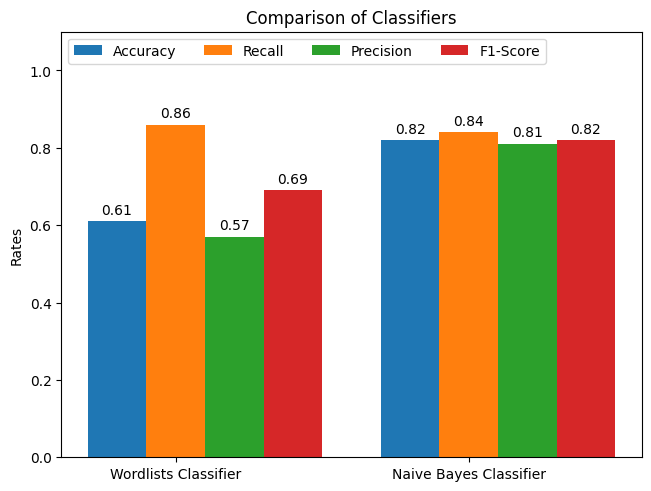

In [109]:
#plotting for comparison of 2 models
import numpy as np
plt.figure(figsize=(10,5))
species = ("Wordlists Classifier", "Naive Bayes Classifier")
parameters = {
    'Accuracy': (round(Accuracy, 2),round(Accuracy_b, 2)),
    'Recall': (round(Recall, 2), round(Recall_b, 2)),
    'Precision': (round(Precision, 2), round(Precision_b, 2)),
    'F1-Score': (round(F1_score, 2), round(F1_score_b, 2))
}

x = np.arange(len(species))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in parameters.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rates')
ax.set_title('Comparison of Classifiers')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 1.1)


plt.show()

*   As it can be seen on the graph, the only parameter of *“Wordlists Classifier”* higher than “Naive Bayes Classifier” is **recall**(0.86). Recall gives success rate in real positive values, so the first classifer seems that it detects the positive reviews better. However, Naive Bayes Classifier doesn’t work bad neither.

*  When it comes to **precision** for Wordlist Classifier specially, we can see that it is tend to makes the movie reviews label by positive more likely, while the success in prediction is not as good as recall. Because of that, consistency of the model cannot be trustable.

*   As for **accuracy**, it’s obvious that the first classifier is pretty poor, since it classifies the data correctly 61%, while Naive Bayes makes it by 82%.

*   Sometimes accuracy doesn’t give an accurate result due to unbalanced data. Even though we know that the dataset is not unbalanced (it can be seen below), checking the parameter of **F1-Score** makes the analysis perfect. Because it’s a kind of harmonic mean in which *precision* and *recall* are taken into account. From this point, it can be proved that Naive Bayes is the winner of the classifiers here.










### Data Distribution Check (whether it's balanced or unbalanced)

In [116]:
#Data distribution check (whether it's balanced or unbalanced)
train_c_pos=0
train_c_neg=0

test_c_pos=0
test_c_neg=0
for i in training_data:
  if i[1]=='neg':
    train_c_neg+=1
  elif i[1]=='pos':
    train_c_pos+=1
for j in testing_data:
  if j[1]=='neg':
    test_c_neg+=1
  elif j[1]=='pos':
    test_c_pos+=1

print("Training Dataset Distribution:\n-----------------------------\nThe number of positive reviews: {}\nThe number of negative reviews: {}\n-----------------------------------\n-----------------------------------\nTesting Dataset Distribution:\n-----------------------------\nThe number of positive reviews: {}\nThe number of negative reviews: {}\n".format(train_c_pos,train_c_neg,test_c_pos,test_c_neg))

Training Dataset Distribution:
-----------------------------
The number of positive reviews: 700
The number of negative reviews: 700
-----------------------------------
-----------------------------------
Testing Dataset Distribution:
-----------------------------
The number of positive reviews: 300
The number of negative reviews: 300



# **QUESTION 5**

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


## **Answer of 5.Question a)**

### **Designing of the experiment:**



*   Because of checking the impact of the length of the wordlists on the classifier called wordlists, the value of the list of element must be changed one by one over the both representative lists.*(Loop is needed.)*

*   The number of the elements must be on the x-axis.*(The variable of the loop must represent the X-axis)*

*   To see how it affects the model, it's better to check the score parameters such as accuracy, and recall, and precision.*(Calculating of these values in each loop and taking them into different lists are necessary.)*

*   The value of these parameters must be on the y-axis.*(Each list of parameter must be specified as Y values.)*

*   Instead of showing all in the same graph, plotting 3 different graphs for each parameter makes understanding easier.*(Subplot is needed.)*










### **Experiment of the impact of the length of the wordlists on the wordlist classifier:**

In [124]:
list_accuracy=[]
list_recall=[]
list_precision=[]
list_i=[]

for i in range(1,200):
  (number_pos,number_neg,total,notr,predicted_list)=wordlist_classifier(testing_data,filtered_pos[:i],filtered_neg[:i])
  (TP,TN,FP,FN,Total,Accuracy,Error_rate,Recall,Precision,F1_score)=wordlist_score_calculator(predicted_list,testing_data)
  list_i.append(i)
  list_accuracy.append(Accuracy)
  list_recall.append(Recall)
  list_precision.append(Precision)

### **Plotting of the Graphs of the Results:**

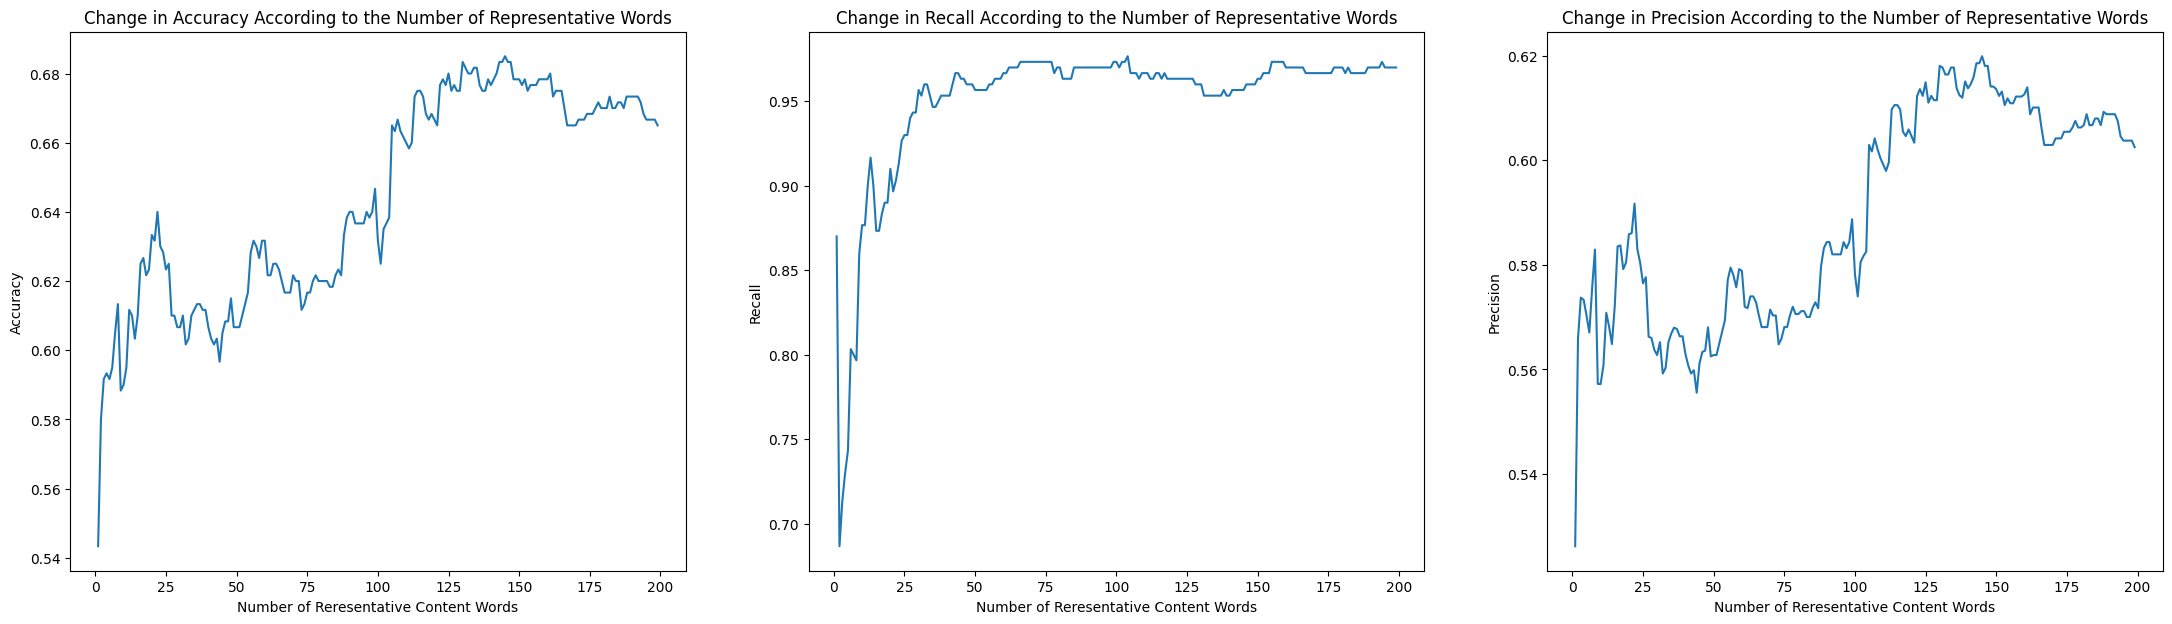

In [125]:
plt.figure(figsize=(27,7))
plt.subplot(1, 3, 1)
plt.plot(list_i,list_accuracy)
plt.xlabel("Number of Reresentative Content Words")
plt.ylabel("Accuracy")
plt.title("Change in Accuracy According to the Number of Representative Words")
plt.subplot(1, 3, 2)
plt.plot(list_i,list_recall)
plt.xlabel("Number of Reresentative Content Words")
plt.ylabel("Recall")
plt.title("Change in Recall According to the Number of Representative Words")
plt.subplot(1, 3, 3)
plt.plot(list_i,list_precision)
plt.xlabel("Number of Reresentative Content Words")
plt.ylabel("Precision")
plt.title("Change in Precision According to the Number of Representative Words")
plt.show()

### **Comments for Graphs:**


*   **Accuracy Graph:** According to the number of content words, it can be seen that the more words, the more accuracy. However, it's not close to the one holding by Naive Bayes. The pick point(around 0.68) of the number of words is about 150 out of 200. Normally, we can get 61% of accuracy by 10 words, so there is no necessity to increase the number of vocabularies to get nearly 7% better result in terms of accuracy.

*   **Recall Graph:** Recall jumps to 97% nearly at the number of 100 roughly (it was 86% with 10 words). If we want to make a model which we care about only real positive success rate, and the time is not important for us, then it can be tried. However, such a model is not preferred when the precision is checked.

*   **Precision Graph:** Not only other parameters increase when the more words are taken into account, but also the precision climbs. When about 150 data is taken, the precision grows by the rate of 5% almost(from 57% to 62%). It gives the success rate in predicted positive labelled data.
----------------------------
Overall, it can be seen that the ratios of all have the minimum value for accuracy and precision, while all jump suddenly just after 100 words.
However, it's not necessary to take 100 or 200 words to get this result which is still not good to make a prediction model for movie reviews or any other field that it can be applied.

## **Answer of 5.Question b)**

*   **Wordlists Classifier:**

1.   **Advantages:**
If we are dealing with a really simple stable problem, and if we can classify the text with the exact keywords, then we can just build this classifier to make up a simple conclusion in a shorter time.

2.   **Disadvantages:**
It cannot work with a new dataset. If the variety of word is wider, it may not work properly.




*   **Naive Bayes Classifier:**

1.   **Advantages:**
It approaches the dataset in a more statistical way by taking likelihood. Hence, it can adapt to a new dataset easily. When we have a more complex dataset, we can see the relationship in a better way.

2.   **Disadvantages:**
Even if it gives more precise result, building up the model takes more time because of having a strong structure made of probability.

--------------
**Recommendation:**
Even though Naive Bayes takes more time, I would recommend ***Naive Bayes Classifier*** instead of *Wordlists Classifier* without any doubts.


# **The Number of Words in the Assignment:**

In [129]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/ANLPassignment2023.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission length is 1340
